## 第五章  PyTorch常用工具模块

在训练神经网络过程中，需要用到很多工具，其中最重要的三部分是：数据、可视化和GPU加速。本章主要介绍Pytorch在这几方面的工具模块，合理使用这些工具能够极大地提高编码效率。

### 5.1 数据处理

在解决深度学习问题的过程中，往往需要花费大量的精力去处理数据，包括图像、文本、语音或其它二进制数据等。数据的处理对训练神经网络来说十分重要，良好的数据处理不仅会加速模型训练，更会提高模型效果。考虑到这点，PyTorch提供了几个高效便捷的工具，以便使用者进行数据处理或增强等操作，同时可通过并行化加速数据加载。

#### 5.1.1 数据加载

在PyTorch中，数据加载可通过自定义的数据集对象。数据集对象被抽象为`Dataset`类，实现自定义的数据集需要继承Dataset，并实现两个Python魔法方法：
- `__getitem__`：返回一条数据，或一个样本。`obj[index]`等价于`obj.__getitem__(index)`
- `__len__`：返回样本的数量。`len(obj)`等价于`obj.__len__()`

这里我们以Kaggle经典挑战赛["Dogs vs. Cat"](https://www.kaggle.com/c/dogs-vs-cats/)的数据为例，来详细讲解如何处理数据。"Dogs vs. Cats"是一个分类问题，判断一张图片是狗还是猫，其所有图片都存放在一个文件夹下，根据文件名的前缀判断是狗还是猫。

In [6]:
%env LS_COLORS = None 
!tree  data/dogcat/ 
#不需要参数 --charset ascii

env: LS_COLORS=None
卷 新加卷 的文件夹 PATH 列表
卷序列号为 C6D4-D21B
D:\PROJECT\GIT\PYTORCH-BOOK\CHAPTER5-常用工具\DATA\DOGCAT\
无效的路径 - \PROJECT\GIT\PYTORCH-BOOK\CHAPTER5-常用工具\DATA\DOGCAT\
没有子文件夹 



In [7]:
import torch as t
from torch.utils import data

In [8]:
import os
from PIL import  Image
import numpy as np

class DogCat(data.Dataset):
    def __init__(self, root):
        imgs = os.listdir(root)
        # 所有图片的绝对路径
        # 这里不实际加载图片，只是指定路径，当调用__getitem__时才会真正读图片
        self.imgs = [os.path.join(root, img) for img in imgs]
        
    def __getitem__(self, index):
        img_path = self.imgs[index]
        # dog->1， cat->0
        label = 1 if 'dog' in img_path.split('/')[-1] else 0
        pil_img = Image.open(img_path)
        array = np.asarray(pil_img)
        data = t.from_numpy(array)
        return data, label
    
    def __len__(self):
        return len(self.imgs)

In [9]:
dataset = DogCat('./data/dogcat/')
img, label = dataset[0] # 相当于调用dataset.__getitem__(0)
for img, label in dataset:
    print(img.size(), img.float().mean(), label)

torch.Size([500, 497, 3]) tensor(106.4917) 0
torch.Size([499, 379, 3]) tensor(171.8088) 0
torch.Size([236, 289, 3]) tensor(130.3022) 0
torch.Size([374, 499, 3]) tensor(115.5157) 0
torch.Size([375, 499, 3]) tensor(116.8187) 1
torch.Size([375, 499, 3]) tensor(150.5085) 1
torch.Size([377, 499, 3]) tensor(151.7141) 1
torch.Size([400, 300, 3]) tensor(128.1548) 1


通过上面的代码，我们学习了如何自定义自己的数据集，并可以依次获取。但这里返回的数据不适合实际使用，因其具有如下两方面问题：
- 返回样本的形状不一，因每张图片的大小不一样，这对于需要取batch训练的神经网络来说很不友好
- 返回样本的数值较大，未归一化至[-1, 1]

针对上述问题，PyTorch提供了torchvision[^1]。它是一个视觉工具包，提供了很多视觉图像处理的工具，其中`transforms`模块提供了对PIL `Image`对象和`Tensor`对象的常用操作。

对PIL Image的操作包括：
- `Scale`：调整图片尺寸，长宽比保持不变
- `CenterCrop`、`RandomCrop`、`RandomResizedCrop`： 裁剪图片
- `Pad`：填充
- `ToTensor`：将PIL Image对象转成Tensor，会自动将[0, 255]归一化至[0, 1]

对Tensor的操作包括：
- Normalize：标准化，即减均值，除以标准差
- ToPILImage：将Tensor转为PIL Image对象

如果要对图片进行多个操作，可通过`Compose`函数将这些操作拼接起来，类似于`nn.Sequential`。注意，这些操作定义后是以函数的形式存在，真正使用时需调用它的`__call__`方法，这点类似于`nn.Module`。例如要将图片调整为$224\times 224$，首先应构建这个操作`trans = Resize((224, 224))`，然后调用`trans(img)`。下面我们就用transforms的这些操作来优化上面实现的dataset。
[^1]: https://github.com/pytorch/vision/

In [10]:
import os
from PIL import  Image
import numpy as np
from torchvision import transforms as T

transform = T.Compose([
    T.Resize(224), # 缩放图片(Image)，保持长宽比不变，最短边为224像素
    T.CenterCrop(224), # 从图片中间切出224*224的图片
    T.ToTensor(), # 将图片(Image)转成Tensor，归一化至[0, 1]
    T.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5]) # 标准化至[-1, 1]，规定均值和标准差
])

class DogCat(data.Dataset):
    def __init__(self, root, transforms=None):
        imgs = os.listdir(root)
        self.imgs = [os.path.join(root, img) for img in imgs]
        self.transforms=transforms
        
    def __getitem__(self, index):
        img_path = self.imgs[index]
        label = 0 if 'dog' in img_path.split('/')[-1] else 1
        data = Image.open(img_path)
        if self.transforms:
            data = self.transforms(data)
        return data, label
    
    def __len__(self):
        return len(self.imgs)

dataset = DogCat('./data/dogcat/', transforms=transform)
img, label = dataset[0]
for img, label in dataset:
    print(img.size(), label)

torch.Size([3, 224, 224]) 1
torch.Size([3, 224, 224]) 1
torch.Size([3, 224, 224]) 1
torch.Size([3, 224, 224]) 1
torch.Size([3, 224, 224]) 0
torch.Size([3, 224, 224]) 0
torch.Size([3, 224, 224]) 0
torch.Size([3, 224, 224]) 0


除了上述操作之外，transforms还可通过`Lambda`封装自定义的转换策略。例如想对PIL Image进行随机旋转，则可写成这样`trans=T.Lambda(lambda img: img.rotate(random()*360))`。 ps：random()会生成一个\[0，1)之间的随机数。

torchvision已经预先实现了常用的Dataset，包括前面使用过的CIFAR-10，以及ImageNet、COCO、MNIST、LSUN等数据集，可通过诸如`torchvision.datasets.CIFAR10`来调用，具体使用方法请参看官方文档[^1]。在这里介绍一个会经常使用到的Dataset——`ImageFolder`，它的实现和上述的`DogCat`很相似。`ImageFolder`假设所有的文件按文件夹保存，每个文件夹下存储同一个类别的图片，文件夹名为类名，其构造函数如下：
```
ImageFolder(root, transform=None, target_transform=None, loader=default_loader)
```
它主要有四个参数：
- `root`：在root指定的路径下寻找图片
- `transform`：对PIL Image进行的转换操作，transform的输入是使用loader读取图片的返回对象
- `target_transform`：对label的转换
- `loader`：给定路径后如何读取图片，默认读取为RGB格式的PIL Image对象

label是按照文件夹名顺序排序后存成字典，即{类名:类序号(从0开始)}，一般来说最好直接将文件夹命名为从0开始的数字，这样会和ImageFolder实际的label一致，如果不是这种命名规范，建议看看`self.class_to_idx`属性以了解label和文件夹名的映射关系。

[^1]: http://pytorch.org/docs/master/torchvision/datasets.html

In [11]:
!tree --charset ASCII  data/dogcat_2/

参数太多 - ASCII


In [12]:
from torchvision.datasets import ImageFolder
dataset = ImageFolder('data/dogcat_2/')

In [13]:
# cat文件夹的图片对应label 0，dog对应1
dataset.class_to_idx

{'cat': 0, 'dog': 1}

In [14]:
# 所有图片的路径和对应的label
dataset.imgs

[('data/dogcat_2/cat\\cat.12484.jpg', 0),
 ('data/dogcat_2/cat\\cat.12485.jpg', 0),
 ('data/dogcat_2/cat\\cat.12486.jpg', 0),
 ('data/dogcat_2/cat\\cat.12487.jpg', 0),
 ('data/dogcat_2/dog\\dog.12496.jpg', 1),
 ('data/dogcat_2/dog\\dog.12497.jpg', 1),
 ('data/dogcat_2/dog\\dog.12498.jpg', 1),
 ('data/dogcat_2/dog\\dog.12499.jpg', 1)]

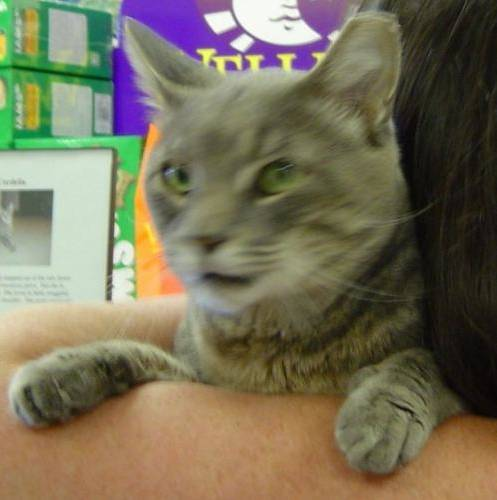

In [15]:
# 没有任何的transform，所以返回的还是PIL Image对象
dataset[0][1] # 第一维是第几张图，第二维为1返回label
dataset[0][0] # 为0返回图片数据

In [16]:
# 加上transform
normalize = T.Normalize(mean=[0.4, 0.4, 0.4], std=[0.2, 0.2, 0.2])
transform  = T.Compose([
         T.RandomResizedCrop(224),
         T.RandomHorizontalFlip(),
         T.ToTensor(),
         normalize,
])

In [17]:
dataset = ImageFolder('data/dogcat_2/', transform=transform)

In [18]:
# 深度学习中图片数据一般保存成CxHxW，即通道数x图片高x图片宽
dataset[0][0].size()

torch.Size([3, 224, 224])

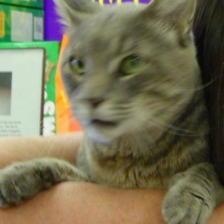

In [19]:
to_img = T.ToPILImage()
# 0.2和0.4是标准差和均值的近似
to_img(dataset[0][0]*0.2+0.4)

`Dataset`只负责数据的抽象，一次调用`__getitem__`只返回一个样本。前面提到过，在训练神经网络时，最好是对一个batch的数据进行操作，同时还需要对数据进行shuffle和并行加速等。对此，PyTorch提供了`DataLoader`帮助我们实现这些功能。

DataLoader的函数定义如下： 
`DataLoader(dataset, batch_size=1, shuffle=False, sampler=None, num_workers=0, collate_fn=default_collate, pin_memory=False, drop_last=False)`

- dataset：加载的数据集(Dataset对象)
- batch_size：batch size
- shuffle:：是否将数据打乱
- sampler： 样本抽样，后续会详细介绍
- num_workers：使用多进程加载的进程数，0代表不使用多进程
- collate_fn： 如何将多个样本数据拼接成一个batch，一般使用默认的拼接方式即可
- pin_memory：是否将数据保存在pin memory区，pin memory中的数据转到GPU会快一些
- drop_last：dataset中的数据个数可能不是batch_size的整数倍，drop_last为True会将多出来不足一个batch的数据丢弃

In [23]:
from torch.utils.data import DataLoader

In [24]:
dataloader = DataLoader(dataset, batch_size=3, shuffle=True, num_workers=0, drop_last=False)

In [25]:
dataiter = iter(dataloader)
imgs, labels = next(dataiter)
imgs.size() # batch_size, channel, height, weight

torch.Size([3, 3, 224, 224])

dataloader是一个可迭代的对象，意味着我们可以像使用迭代器一样使用它，例如：
```python
for batch_datas, batch_labels in dataloader:
    train()
```
或
```
dataiter = iter(dataloader)
batch_datas, batch_labesl = next(dataiter)
```

在数据处理中，有时会出现某个样本无法读取等问题，比如某张图片损坏。这时在`__getitem__`函数中将出现异常，此时最好的解决方案即是将出错的样本剔除。如果实在是遇到这种情况无法处理，则可以返回None对象，然后在`Dataloader`中实现自定义的`collate_fn`，将空对象过滤掉。但要注意，在这种情况下dataloader返回的batch数目会少于batch_size。

In [26]:
class NewDogCat(DogCat): # 继承前面实现的DogCat数据集
    def __getitem__(self, index):
        try:
            # 调用父类的获取函数，即 DogCat.__getitem__(self, index)
            return super(NewDogCat,self).__getitem__(index)
        except:
            return None, None

from torch.utils.data.dataloader import default_collate # 导入默认的拼接方式
def my_collate_fn(batch):
    '''
    batch中每个元素形如(data, label)
    '''
    # 过滤为None的数据
    batch = list(filter(lambda x:x[0] is not None, batch))
    if len(batch) == 0: return t.Tensor()
    return default_collate(batch) # 用默认方式拼接过滤后的batch数据

In [27]:
dataset = NewDogCat('data/dogcat_wrong/', transforms=transform)

In [28]:
dataset[5]

(tensor([[[ 2.8235,  2.8431,  2.8824,  ...,  0.0196,  0.0000, -0.0196],
          [ 2.8431,  2.8627,  2.9020,  ...,  0.0392,  0.0196,  0.0196],
          [ 2.8627,  2.8824,  2.9216,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.4706,  0.4314,  0.3922,  ..., -0.6667, -0.7059, -0.7255],
          [ 0.4314,  0.3922,  0.3529,  ..., -0.6863, -0.7059, -0.7059],
          [ 0.4118,  0.3725,  0.3333,  ..., -0.7059, -0.6863, -0.6667]],
 
         [[ 2.8235,  2.8824,  2.9608,  ...,  0.4902,  0.4902,  0.4902],
          [ 2.8039,  2.8627,  2.9412,  ...,  0.5294,  0.5294,  0.5294],
          [ 2.8039,  2.8627,  2.9412,  ...,  0.4902,  0.5098,  0.5098],
          ...,
          [ 0.1961,  0.1765,  0.1569,  ..., -0.6078, -0.6471, -0.6667],
          [ 0.1765,  0.1569,  0.1373,  ..., -0.6275, -0.6471, -0.6471],
          [ 0.1569,  0.1373,  0.0980,  ..., -0.6471, -0.6275, -0.6078]],
 
         [[ 2.1176,  2.1961,  2.3137,  ...,  1.6667,  1.6471,  1.6471],
          [ 2.1176,  2.1961,

In [ ]:
dataloader = DataLoader(dataset, 2, collate_fn=my_collate_fn, num_workers=1,shuffle=True)
for batch_datas, batch_labels in dataloader:
    print(batch_datas.size(),batch_labels.size())

来看一下上述batch_size的大小。其中第2个的batch_size为1，这是因为有一张图片损坏，导致其无法正常返回。而最后1个的batch_size也为1，这是因为共有9张（包括损坏的文件）图片，无法整除2（batch_size），因此最后一个batch的数据会少于batch_szie，可通过指定`drop_last=True`来丢弃最后一个不足batch_size的batch。

对于诸如样本损坏或数据集加载异常等情况，还可以通过其它方式解决。例如但凡遇到异常情况，就随机取一张图片代替：
```python
class NewDogCat(DogCat):
    def __getitem__(self, index):
        try:
            return super(NewDogCat, self).__getitem__(index)
        except:
            new_index = random.randint(0, len(self)-1)
            return self[new_index]
```
相比较丢弃异常图片而言，这种做法会更好一些，因为它能保证每个batch的数目仍是batch_size。但在大多数情况下，最好的方式还是对数据进行彻底清洗。

DataLoader里面并没有太多的魔法方法，它封装了Python的标准库`multiprocessing`，使其能够实现多进程加速。在此提几点关于Dataset和DataLoader使用方面的建议：
1. 高负载的操作放在`__getitem__`中，如加载图片等。
2. dataset中应尽量只包含只读对象，避免修改任何可变对象，利用多线程进行操作。

第一点是因为多进程会并行的调用`__getitem__`函数，将负载高的放在`__getitem__`函数中能够实现并行加速。
第二点是因为dataloader使用多进程加载，如果在`Dataset`实现中使用了可变对象，可能会有意想不到的冲突。在多线程/多进程中，修改一个可变对象，需要加锁，但是dataloader的设计使得其很难加锁（在实际使用中也应尽量避免锁的存在），因此最好避免在dataset中修改可变对象。例如下面就是一个不好的例子，在多进程处理中`self.num`可能与预期不符，这种问题不会报错，因此难以发现。如果一定要修改可变对象，建议使用Python标准库`Queue`中的相关数据结构。

```python
class BadDataset(Dataset):
    def __init__(self):
        self.datas = range(100)
        self.num = 0 # 取数据的次数
    def __getitem__(self, index):
        self.num += 1
        return self.datas[index]
```

使用Python `multiprocessing`库的另一个问题是，在使用多进程时，如果主程序异常终止（比如用Ctrl+C强行退出），相应的数据加载进程可能无法正常退出。这时你可能会发现程序已经退出了，但GPU显存和内存依旧被占用着，或通过`top`、`ps aux`依旧能够看到已经退出的程序，这时就需要手动强行杀掉进程。建议使用如下命令：

```
ps x | grep <cmdline> | awk '{print $1}' | xargs kill
```

- `ps x`：获取当前用户的所有进程
- `grep <cmdline>`：找到已经停止的PyTorch程序的进程，例如你是通过python train.py启动的，那你就需要写`grep 'python train.py'`
- `awk '{print $1}'`：获取进程的pid
- `xargs kill`：杀掉进程，根据需要可能要写成`xargs kill -9`强制杀掉进程

在执行这句命令之前，建议先打印确认一下是否会误杀其它进程
```
ps x | grep <cmdline> | ps x
```

PyTorch中还单独提供了一个`sampler`模块，用来对数据进行采样。常用的有随机采样器：`RandomSampler`，当dataloader的`shuffle`参数为True时，系统会自动调用这个采样器，实现打乱数据。默认的是采用`SequentialSampler`，它会按顺序一个一个进行采样。这里介绍另外一个很有用的采样方法：
`WeightedRandomSampler`，它会根据每个样本的权重选取数据，在样本比例不均衡的问题中，可用它来进行重采样。

构建`WeightedRandomSampler`时需提供两个参数：每个样本的权重`weights`、共选取的样本总数`num_samples`，以及一个可选参数`replacement`。权重越大的样本被选中的概率越大，待选取的样本数目一般小于全部的样本数目。`replacement`用于指定是否可以重复选取某一个样本，默认为True，即允许在一个epoch中重复采样某一个数据。如果设为False，则当某一类的样本被全部选取完，但其样本数目仍未达到num_samples时，sampler将不会再从该类中选择数据，此时可能导致`weights`参数失效。下面举例说明。

In [ ]:
dataset = DogCat('data/dogcat/', transforms=transform)

# 狗的图片被取出的概率是猫的概率的两倍
# 两类图片被取出的概率与weights的绝对大小无关，只和比值有关
weights = [2 if label == 1 else 1 for data, label in dataset]
weights

In [ ]:
from torch.utils.data.sampler import  WeightedRandomSampler
sampler = WeightedRandomSampler(weights,\
                                num_samples=9,\
                                replacement=True)
dataloader = DataLoader(dataset,
                        batch_size=3,
                        sampler=sampler)
for datas, labels in dataloader:
    print(labels.tolist())

可见猫狗样本比例约为1:2，另外一共只有8个样本，但是却返回了9个，说明肯定有被重复返回的，这就是replacement参数的作用，下面将replacement设为False试试。

In [ ]:
sampler = WeightedRandomSampler(weights, 8, replacement=False)
dataloader = DataLoader(dataset, batch_size=4, sampler=sampler)
for datas, labels in dataloader:
    print(labels.tolist())

在这种情况下，num_samples等于dataset的样本总数，为了不重复选取，sampler会将每个样本都返回，这样就失去weight参数的意义了。

从上面的例子可见sampler在样本采样中的作用：如果指定了sampler，shuffle将不再生效，并且sampler.num_samples会覆盖dataset的实际大小，即一个epoch返回的图片总数取决于`sampler.num_samples`。

### 5.2 计算机视觉工具包：torchvision
计算机视觉是深度学习中最重要的一类应用，为了方便研究者使用，PyTorch团队专门开发了一个视觉工具包`torchvion`，这个包独立于PyTorch，需通过`pip instal torchvision`安装。在之前的例子中我们已经见识到了它的部分功能，这里再做一个系统性的介绍。torchvision主要包含三部分：

- models：提供深度学习中各种经典网络的网络结构以及预训练好的模型，包括`AlexNet`、VGG系列、ResNet系列、Inception系列等。
- datasets： 提供常用的数据集加载，设计上都是继承`torhc.utils.data.Dataset`，主要包括`MNIST`、`CIFAR10/100`、`ImageNet`、`COCO`等。
- transforms：提供常用的数据预处理操作，主要包括对Tensor以及PIL Image对象的操作。

In [ ]:
from torchvision import models
from torch import nn
# 加载预训练好的模型，如果不存在会进行下载
# 预训练好的模型保存在 ~/.torch/models/下面
resnet34 = models.squeezenet1_1(pretrained=True, num_classes=1000)

# 修改最后的全连接层为10分类问题（默认是ImageNet上的1000分类）
resnet34.fc=nn.Linear(512, 10)

In [ ]:
from torchvision import datasets
# 指定数据集路径为data，如果数据集不存在则进行下载
# 通过train=False获取测试集
dataset = datasets.MNIST('data/', download=True, train=False, transform=transform)

Transforms中涵盖了大部分对Tensor和PIL Image的常用处理，这些已在上文提到，这里就不再详细介绍。需要注意的是转换分为两步，第一步：构建转换操作，例如`transf = transforms.Normalize(mean=x, std=y)`，第二步：执行转换操作，例如`output = transf(input)`。另外还可将多个处理操作用Compose拼接起来，形成一个处理转换流程。

In [ ]:
from torchvision import transforms 
to_pil = transforms.ToPILImage()
to_pil(t.randn(3, 64, 64))

torchvision还提供了两个常用的函数。一个是`make_grid`，它能将多张图片拼接成一个网格中；另一个是`save_img`，它能将Tensor保存成图片。

In [ ]:
len(dataset)

In [ ]:
dataloader = DataLoader(dataset, shuffle=True, batch_size=16)
from torchvision.utils import make_grid, save_image
dataiter = iter(dataloader)
img = make_grid(next(dataiter)[0], 4) # 拼成4*4网格图片，且会转成３通道
to_img(img)

In [ ]:
save_image(img, 'a.png')
Image.open('a.png')

### 5.3 可视化工具
在训练神经网络时，我们希望能更直观地了解训练情况，包括损失曲线、输入图片、输出图片、卷积核的参数分布等信息。这些信息能帮助我们更好地监督网络的训练过程，并为参数优化提供方向和依据。最简单的办法就是打印输出，但其只能打印数值信息，不够直观，同时无法查看分布、图片、声音等。在本节，我们将介绍两个深度学习中常用的可视化工具：Tensorboard和Visdom。

#### 5.3.1 Tensorboard

Tensorboard最初是作为TensorFlow的可视化工具迅速流行开来。作为和TensorFlow深度集成的工具，Tensorboard能够展现你的TensorFlow网络计算图，绘制图像生成的定量指标图以及附加数据。但同时Tensorboard也是一个相对独立的工具，只要用户保存的数据遵循相应的格式，tensorboard就能读取这些数据并进行可视化。这里我们将主要介绍如何在PyTorch中使用tensorboardX[^1]进行训练损失的可视化。
TensorboardX是将Tensorboard的功能抽取出来，使得非TensorFlow用户也能使用它进行可视化，几乎支持原生TensorBoard的全部功能。

![图1；tensorboard界面](imgs/tensorboard.png)
[^1]:https://github.com/lanpa/tensorboardX

tensorboard的安装主要分为以下两步：
- 安装TensorFlow：如果电脑中已经安装完TensorFlow可以跳过这一步，如果电脑中尚未安装，建议安装CPU-Only的版本，具体安装教程参见TensorFlow官网[^1]，或使用pip直接安装，推荐使用清华的软件源[^2]。
- 安装tensorboard: `pip install tensorboard`
- 安装tensorboardX：可通过`pip install tensorboardX`命令直接安装。

tensorboardX的使用非常简单。首先用如下命令启动tensorboard：
```bash
tensorboard --logdir <your/running/dir> --port <your_bind_port>
```

下面举例说明tensorboardX的使用。

[^1]: https://www.tensorflow.org/install/
[^2]: https://mirrors.tuna.tsinghua.edu.cn/help/tensorflow/

In [ ]:
from tensorboardX import SummaryWriter

In [ ]:
# 构建logger对象，logdir用来指定log文件的保存路径
# flush_secs用来指定刷新同步间隔
logger = SummaryWriter(log_dir='experimient_cnn', flush_secs=2)

In [ ]:
for ii in range(100):
    logger.add_scalar('data/loss', 10-ii**0.5)
    logger.add_scalar('data/accuracy', ii**0.5/10)

打开浏览器输入`http://localhost:6006`（其中6006应改成你的tensorboard所绑定的端口），即可看到如图2所示的结果。
![图2: tensorboard可视化结果](imgs/tensorboard2.png)
左侧的Horizontal Axis下有三个选项，分别是：
- Step：根据步长来记录，log_value时如果有步长，则将其作为x轴坐标描点画线。
- Relative：用前后相对顺序描点画线，可认为logger自己维护了一个`step`属性，每调用一次log_value就自动加１。
- Wall：按时间排序描点画线。

左侧的Smoothing条可以左右拖动，用来调节平滑的幅度。点击右上角的刷新按钮可立即刷新结果，默认是每30s自动刷新数据。可见tensorboard_logger的使用十分简单，但它只能统计简单的数值信息，不支持其它功能。

感兴趣的读者可以从github项目主页获取更多信息，本节将把更多的内容留给另一个可视化工具：Visdom。
[^4]: https://github.com/lanpa/tensorboard-pytorch

#### 5.3.2 Visdom
Visdom[^5]是Facebook专门为PyTorch开发的一款可视化工具，其开源于2017年3月。Visdom十分轻量级，但却支持非常丰富的功能，能胜任大多数的科学运算可视化任务。其可视化界面如图3所示。

![图3: visdom界面](imgs/visdom.png)
[^5]: https://github.com/facebookresearch/visdom

Visdom可以创造、组织和共享多种数据的可视化，包括数值、图像、文本，甚至是视频，其支持PyTorch、Torch及Numpy。用户可通过编程组织可视化空间，或通过用户接口为生动数据打造仪表板，检查实验结果或调试代码。

Visdom中有两个重要概念：
- env：环境。不同环境的可视化结果相互隔离，互不影响，在使用时如果不指定env，默认使用`main`。不同用户、不同程序一般使用不同的env。
- pane：窗格。窗格可用于可视化图像、数值或打印文本等，其可以拖动、缩放、保存和关闭。一个程序中可使用同一个env中的不同pane，每个pane可视化或记录某一信息。

如图4所示，当前env共有两个pane，一个用于打印log，另一个用于记录损失函数的变化。点击clear按钮可以清空当前env的所有pane，点击save按钮可将当前env保存成json文件，保存路径位于`~/.visdom/`目录下。也可修改env的名字后点击fork，保存当前env的状态至更名后的env。
![图4：visdom_env](imgs/visdom_env_pane.png)

Visdom的安装可通过命令`pip install visdom`。安装完成后，需通过`python -m visdom.server`命令启动visdom服务，或通过`nohup python -m visdom.server &`命令将服务放至后台运行。Visdom服务是一个web server服务，默认绑定8097端口，客户端与服务器间通过tornado进行非阻塞交互。

Visdom的使用有两点需要注意的地方：
- 需手动指定保存env，可在web界面点击save按钮或在程序中调用save方法，否则visdom服务重启后，env等信息会丢失。
- 客户端与服务器之间的交互采用tornado异步框架，可视化操作不会阻塞当前程序，网络异常也不会导致程序退出。

Visdom以Plotly为基础，支持丰富的可视化操作，下面举例说明一些最常用的操作。

In [ ]:
%%sh
# 启动visdom服务器
# nohup python -m visdom.server &

In [ ]:

import torch as t

In [ ]:
import visdom

# 新建一个连接客户端
# 指定env = u'test1'，默认端口为8097，host是‘localhost'
vis = visdom.Visdom(env=u'test1',use_incoming_socket=False)

x = t.arange(1, 30, 0.01)
y = t.sin(x)
vis.line(X=x, Y=y, win='sinx', opts={'title': 'y=sin(x)'})

输出的结果如图5所示。
![图5： visdom的输出](imgs/visdom_sinx.png)

下面逐一分析这几行代码：
- vis = visdom.Visdom(env=u'test1')，用于构建一个客户端，客户端除指定env之外，还可以指定host、port等参数。
- vis作为一个客户端对象，可以使用常见的画图函数，包括：

    - line：类似Matlab中的`plot`操作，用于记录某些标量的变化，如损失、准确率等
    - image：可视化图片，可以是输入的图片，也可以是GAN生成的图片，还可以是卷积核的信息
    - text：用于记录日志等文字信息，支持html格式
    - histgram：可视化分布，主要是查看数据、参数的分布
    - scatter：绘制散点图
    - bar：绘制柱状图
    - pie：绘制饼状图
    - 更多操作可参考visdom的github主页
    
这里主要介绍深度学习中常见的line、image和text操作。

Visdom同时支持PyTorch的tensor和Numpy的ndarray两种数据结构，但不支持Python的int、float等类型，因此每次传入时都需先将数据转成ndarray或tensor。上述操作的参数一般不同，但有两个参数是绝大多数操作都具备的：
- win：用于指定pane的名字，如果不指定，visdom将自动分配一个新的pane。如果两次操作指定的win名字一样，新的操作将覆盖当前pane的内容，因此建议每次操作都重新指定win。
- opts：选项，接收一个字典，常见的option包括`title`、`xlabel`、`ylabel`、`width`等，主要用于设置pane的显示格式。

之前提到过，每次操作都会覆盖之前的数值，但往往我们在训练网络的过程中需不断更新数值，如损失值等，这时就需要指定参数`update='append'`来避免覆盖之前的数值。而除了使用update参数以外，还可以使用`vis.updateTrace`方法来更新图，但`updateTrace`不仅能在指定pane上新增一个和已有数据相互独立的Trace，还能像`update='append'`那样在同一条trace上追加数据。

In [ ]:
# append 追加数据
for ii in range(0, 10):
    # y = x
    x = t.Tensor([ii])
    y = x
    vis.line(X=x, Y=y, win='polynomial', update='append' if ii>0 else None)
    
# updateTrace 新增一条线
x = t.arange(0, 9, 0.1)
y = (x ** 2) / 9
vis.line(X=x, Y=y, win='polynomial', name='this is a new Trace',update='new')

打开浏览器，输入`http://localhost:8097`，可以看到如图6所示的结果。
![图6 ：append和updateTrace可视化效果 ](imgs/visdom_update.svg)

image的画图功能可分为如下两类：
- `image`接收一个二维或三维向量，$H\times W$或$3 \times H\times W$，前者是黑白图像，后者是彩色图像。
- `images`接收一个四维向量$N\times C\times H\times W$，$C$可以是1或3，分别代表黑白和彩色图像。可实现类似torchvision中make_grid的功能，将多张图片拼接在一起。`images`也可以接收一个二维或三维的向量，此时它所实现的功能与image一致。

In [ ]:
# 可视化一个随机的黑白图片
vis.image(t.randn(64, 64).numpy())

# 随机可视化一张彩色图片
vis.image(t.randn(3, 64, 64).numpy(), win='random2')

# 可视化36张随机的彩色图片，每一行6张
vis.images(t.randn(36, 3, 64, 64).numpy(), nrow=6, win='random3', opts={'title':'random_imgs'})

其中images的可视化输出如图7所示。
![图7： images可视化输出](imgs/visdom_images.png)

`vis.text`用于可视化文本，支持所有的html标签，同时也遵循着html的语法标准。例如，换行需使用`<br>`标签，`\r\n`无法实现换行。下面举例说明。

In [ ]:
vis.text(u'''<h1>Hello Visdom</h1><br>Visdom是Facebook专门为<b>PyTorch</b>开发的一个可视化工具，
         在内部使用了很久，在2017年3月份开源了它。
         
         Visdom十分轻量级，但是却有十分强大的功能，支持几乎所有的科学运算可视化任务''',
         win='visdom',
         opts={'title': u'visdom简介' }
        )

![图8：text的可视化输出](imgs/visdom_text.png)

### 5.4 使用GPU加速：cuda
这部分内容在前面介绍Tensor、Module时大都提到过，这里将做一个总结，并深入介绍相关应用。

在PyTorch中以下数据结构分为CPU和GPU两个版本：
- Tensor
- nn.Module（包括常用的layer、loss function，以及容器Sequential等）

它们都带有一个`.cuda`方法，调用此方法即可将其转为对应的GPU对象。注意，`tensor.cuda`会返回一个新对象，这个新对象的数据已转移至GPU，而之前的tensor还在原来的设备上（CPU）。而`module.cuda`则会将所有的数据都迁移至GPU，并返回自己。所以`module = module.cuda()`和`module.cuda()`所起的作用一致。

nn.Module在GPU与CPU之间的转换，本质上还是利用了Tensor在GPU和CPU之间的转换。`nn.Module`的cuda方法是将nn.Module下的所有parameter（包括子module的parameter）都转移至GPU，而Parameter本质上也是tensor(Tensor的子类)。

下面将举例说明，这部分代码需要你具有两块GPU设备。

P.S. 为什么将数据转移至GPU的方法叫做`.cuda`而不是`.gpu`，就像将数据转移至CPU调用的方法是`.cpu`？这是因为GPU的编程接口采用CUDA，而目前并不是所有的GPU都支持CUDA，只有部分Nvidia的GPU才支持。PyTorch未来可能会支持AMD的GPU，而AMD GPU的编程接口采用OpenCL，因此PyTorch还预留着`.cl`方法，用于以后支持AMD等的GPU。

In [ ]:
tensor = t.Tensor(3, 4)
# 返回一个新的tensor，保存在第1块GPU上，但原来的tensor并没有改变
tensor.cuda(0)
tensor.is_cuda # False

In [ ]:
# 不指定所使用的GPU设备，将默认使用第1块GPU
tensor = tensor.cuda()
tensor.is_cuda # True

In [ ]:
module = nn.Linear(3, 4)
module.cuda(device = 1)
module.weight.is_cuda # True

In [ ]:
class VeryBigModule(nn.Module):
    def __init__(self):
        super(VeryBigModule, self).__init__()
        self.GiantParameter1 = t.nn.Parameter(t.randn(100000, 20000)).cuda(0)
        self.GiantParameter2 = t.nn.Parameter(t.randn(20000, 100000)).cuda(1)
    
    def forward(self, x):
        x = self.GiantParameter1.mm(x.cuda(0))
        x = self.GiantParameter2.mm(x.cuda(1))
        return x

上面最后一部分中，两个Parameter所占用的内存空间都非常大，大概是8个G，如果将这两个都同时放在一块GPU上几乎会将显存占满，无法再进行任何其它运算。此时可通过这种方式将不同的计算分布到不同的GPU中。

关于使用GPU的一些建议：
- GPU运算很快，但对于很小的运算量来说，并不能体现出它的优势，因此对于一些简单的操作可直接利用CPU完成
- 数据在CPU和GPU之间，以及GPU与GPU之间的传递会比较耗时，应当尽量避免
- 在进行低精度的计算时，可以考虑`HalfTensor`，它相比于`FloatTensor`能节省一半的显存，但需千万注意数值溢出的情况。

另外这里需要专门提一下，大部分的损失函数也都属于`nn.Moudle`，但在使用GPU时，很多时候我们都忘记使用它的`.cuda`方法，这在大多数情况下不会报错，因为损失函数本身没有可学习的参数（learnable parameters）。但在某些情况下会出现问题，为了保险起见同时也为了代码更规范，应记得调用`criterion.cuda`。下面举例说明。

In [ ]:
# 交叉熵损失函数，带权重
criterion = t.nn.CrossEntropyLoss(weight=t.Tensor([1, 3]))
input = t.randn(4, 2).cuda()
target = t.Tensor([1, 0, 0, 1]).long().cuda()

# 下面这行会报错，因weight未被转移至GPU
# loss = criterion(input, target)

# 这行则不会报错
criterion.cuda()
loss = criterion(input, target)

criterion._buffers

而除了调用对象的`.cuda`方法之外，还可以使用`torch.cuda.device`，来指定默认使用哪一块GPU，或使用`torch.set_default_tensor_type`使程序默认使用GPU，不需要手动调用cuda。

In [ ]:
# 如果未指定使用哪块GPU，默认使用GPU 0
x = t.cuda.FloatTensor(2, 3)
# x.get_device() == 0
y = t.FloatTensor(2, 3).cuda()
# y.get_device() == 0

# 指定默认使用GPU 1
with t.cuda.device(1):    
    # 在GPU 1上构建tensor
    a = t.cuda.FloatTensor(2, 3)

    # 将tensor转移至GPU 1
    b = t.FloatTensor(2, 3).cuda()
    print(a.get_device() == b.get_device() == 1 )

    c = a + b
    print(c.get_device() == 1)

    z = x + y
    print(z.get_device() == 0)

    # 手动指定使用GPU 0
    d = t.randn(2, 3).cuda(0)
    print(d.get_device() == 2)

In [ ]:
t.set_default_tensor_type('torch.cuda.FloatTensor') # 指定默认tensor的类型为GPU上的FloatTensor
a = t.ones(2, 3)
a.is_cuda

如果服务器具有多个GPU，`tensor.cuda()`方法会将tensor保存到第一块GPU上，等价于`tensor.cuda(0)`。此时如果想使用第二块GPU，需手动指定`tensor.cuda(1)`，而这需要修改大量代码，很是繁琐。这里有两种替代方法：

- 一种是先调用`t.cuda.set_device(1)`指定使用第二块GPU，后续的`.cuda()`都无需更改，切换GPU只需修改这一行代码。
- 更推荐的方法是设置环境变量`CUDA_VISIBLE_DEVICES`，例如当`export CUDA_VISIBLE_DEVICE=1`（下标是从0开始，1代表第二块GPU），只使用第二块物理GPU，但在程序中这块GPU会被看成是第一块逻辑GPU，因此此时调用`tensor.cuda()`会将Tensor转移至第二块物理GPU。`CUDA_VISIBLE_DEVICES`还可以指定多个GPU，如`export CUDA_VISIBLE_DEVICES=0,2,3`，那么第一、三、四块物理GPU会被映射成第一、二、三块逻辑GPU，`tensor.cuda(1)`会将Tensor转移到第三块物理GPU上。

设置`CUDA_VISIBLE_DEVICES`有两种方法，一种是在命令行中`CUDA_VISIBLE_DEVICES=0,1 python main.py`，一种是在程序中`import os;os.environ["CUDA_VISIBLE_DEVICES"] = "2"`。如果使用IPython或者Jupyter notebook，还可以使用`%env CUDA_VISIBLE_DEVICES=1,2`来设置环境变量。

从 0.4 版本开始，pytorch新增了`tensor.to(device)`方法，能够实现设备透明，便于实现CPU/GPU兼容。这部份内容已经在第三章讲解过了。

从PyTorch 0.2版本中，PyTorch新增分布式GPU支持。分布式是指有多个GPU在多台服务器上，而并行一般指的是一台服务器上的多个GPU。分布式涉及到了服务器之间的通信，因此比较复杂，PyTorch封装了相应的接口，可以用几句简单的代码实现分布式训练。分布式对普通用户来说比较遥远，因为搭建一个分布式集群的代价十分大，使用也比较复杂。相比之下一机多卡更加现实。对于分布式训练，这里不做太多的介绍，感兴趣的读者可参考文档[^distributed]。
[^distributed]: http://pytorch.org/docs/distributed.html

#### 5.4.1 单机多卡并行
要实现模型单机多卡十分容易，直接使用 `new_module = nn.DataParallel(module, device_ids)`, 默认会把模型分布到所有的卡上。多卡并行的机制如下：
- 将模型（module）复制到每一张卡上
- 将形状为（N,C,H,W）的输入均等分为 n份（假设有n张卡），每一份形状是（N/n, C,H,W）,然后在每张卡前向传播，反向传播，梯度求平均。要求batch-size 大于等于卡的个数(N>=n)

在绝大多数情况下，new_module的用法和module一致，除了极其特殊的情况下（RNN中的PackedSequence）。另外想要获取原始的单卡模型，需要通过`new_module.module`访问。

#### 5.4.2 多机分布式

### 5.5  持久化
在PyTorch中，以下对象可以持久化到硬盘，并能通过相应的方法加载到内存中：
- Tensor
- Variable
- nn.Module
- Optimizer

本质上上述这些信息最终都是保存成Tensor。Tensor的保存和加载十分的简单，使用t.save和t.load即可完成相应的功能。在save/load时可指定使用的pickle模块，在load时还可将GPU tensor映射到CPU或其它GPU上。

我们可以通过`t.save(obj, file_name)`等方法保存任意可序列化的对象，然后通过`obj = t.load(file_name)`方法加载保存的数据。对于Module和Optimizer对象，这里建议保存对应的`state_dict`，而不是直接保存整个Module/Optimizer对象。Optimizer对象保存的主要是参数，以及动量信息，通过加载之前的动量信息，能够有效地减少模型震荡，下面举例说明。


In [ ]:
a = t.Tensor(3, 4)
if t.cuda.is_available():
        a = a.cuda(1) # 把a转为GPU1上的tensor,
        t.save(a,'a.pth')
        
        # 加载为b, 存储于GPU1上(因为保存时tensor就在GPU1上)
        b = t.load('a.pth')
        
        # 加载为c, 存储于CPU
        c = t.load('a.pth', map_location=lambda storage, loc: storage)
        
        # 加载为d, 存储于GPU0上
        d = t.load('a.pth', map_location={'cuda:1':'cuda:0'})

In [ ]:
t.set_default_tensor_type('torch.FloatTensor')
from torchvision.models import SqueezeNet
model = SqueezeNet()
# module的state_dict是一个字典
model.state_dict().keys()

In [ ]:
# Module对象的保存与加载
t.save(model.state_dict(), 'squeezenet.pth')
model.load_state_dict(t.load('squeezenet.pth'))

In [ ]:
optimizer = t.optim.Adam(model.parameters(), lr=0.1)

In [ ]:
t.save(optimizer.state_dict(), 'optimizer.pth')
optimizer.load_state_dict(t.load('optimizer.pth'))

In [ ]:
all_data = dict(
    optimizer = optimizer.state_dict(),
    model = model.state_dict(),
    info = u'模型和优化器的所有参数'
)
t.save(all_data, 'all.pth')

In [ ]:
all_data = t.load('all.pth')
all_data.keys()